# **Modeling and Evaluation Notebook using conventional ML**

## Objectives

* Answer business requirement 2:
 - the client, can input patient's information and predict whether this patient is likely to be readmitted or not.
* Fit and evaluate a classification model to predict if a patient has heart disease or not.

## Inputs

* outputs/datasets/collection/HospitalReadmissions.csv

## Outputs

* Data cleaning, feature engineering and modelling pipelines
* Feature importance plot 

## Additional Comments

* No additional comments 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

---

## Libraries needed for the notebook

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# to make a pipeline
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# ML algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# to split the dataset
from sklearn.model_selection import train_test_split

# to balance the target variable
from imblearn.over_sampling import SMOTE

# to evaluate the models
from sklearn.metrics import make_scorer, recall_score

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# Load Data

In [5]:
data_path = 'outputs/datasets/collection/HospitalReadmissions.csv'

df = pd.read_csv(data_path).drop(labels=['medical_specialty'], axis=1)
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,0,1,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,0,1,0
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,1,1,1
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,1,1,1
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,0,1,0


In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']

---

## Classification ML Pipeline

### ML pipeline for Data Cleaning and Feature Engineering

In [168]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=categorical_columns)),
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.4, selection_method="variance")),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['age', 'diag_1', 'diag_2', 'diag_3',
                                           'glucose_test', 'A1Ctest'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['time_in_hospital', 'n_procedures',
                                       'n_inpatient', 'n_medications',
                                       'n_lab_procedures'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.4))])

## ML Pipeline with Data

### ML pipeline for Data Cleaning and Feature Engineering

In [169]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection",SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [170]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test set

In [171]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['readmitted'], axis=1),
                                                    df['readmitted'],
                                                    test_size=0.2,
                                                    random_state=0)

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(20000, 15) (20000,) (5000, 15) (5000,)


Data Cleaning Pipeline

In [172]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 13) (20000,) (5000, 13) (5000,)


##### Check Target distribution of the train set

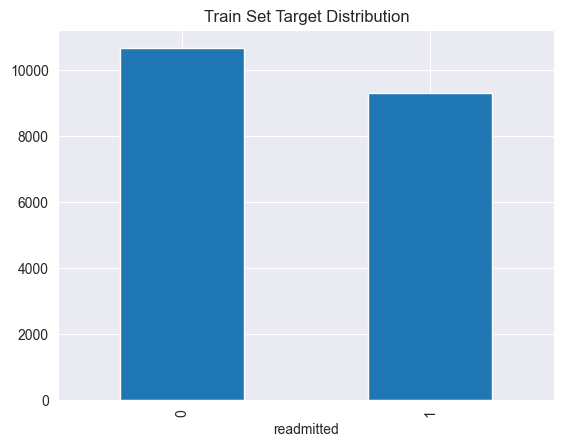

In [173]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

* The target looks relatively balanced, however in order to try and minimise overfitting oversampling will be performed.

In [174]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21360, 13) (21360,) (5000, 13) (5000,)


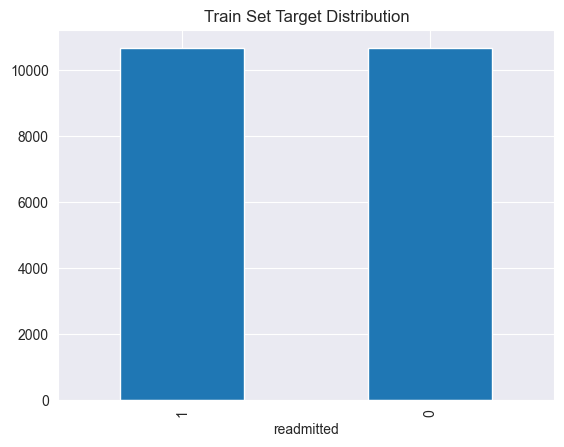

In [175]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Grid Search CV - Sklearn

In [176]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "LogisticRegression": {}
}

Using default hyperparameters to find best algorithm, scored by recall (as per business requirement 2)

Quick GridSearch CV - Binary Classifier

In [177]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Results of GridSearch

In [178]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.503277,0.543352,0.679775,0.068382
5,ExtraTreesClassifier,0.496723,0.542135,0.674625,0.06663
2,DecisionTreeClassifier,0.445693,0.517603,0.634363,0.062419
0,LogisticRegression,0.425562,0.46367,0.497191,0.026892
1,XGBClassifier,0.414326,0.43736,0.466292,0.018925
6,AdaBoostClassifier,0.388109,0.428652,0.457865,0.025524
4,GradientBoostingClassifier,0.373127,0.42191,0.45927,0.030332


The top two algorithms rated by mean score for recall were RandomForestClassifier and ExtraTreesClassifier.
 - RandomForestClassifier : 0.543352
 - ExtraTreesClassifier : 0.542135

The scores are pretty low, so we will proceed with extensive hyperparameter search to see if we can imporove the score.

### Extensive search on the most suitable algorithms

#### Explanation for the hyperparameter selection

* *n_estimators'*:
    - Defines the number of trees in the forest.
    - *Effect:* Increasing the number of trees generally improves the model's performance, as it allows for better averaging and more robust predictions.  
* *max_depth'*: 
    - Sets the maximum depth of each decision tree in the forest. It limits how deep the tree can grow.
    - *Effect:* Restricting the max_depth helps to prevent over fitting by limiting the model's complexity.
* *min_samples_leaf*': 
    - This is the minimum number of samples that must be present in a leaf node.
    - *Effect:* With min_samples_leaf set to 1, leaf nodes can contain a single sample. This setting allows the trees to be very flexible, but it can also make the model more prone to overfitting, especially if the trees are deep.
* *min_samples_split'*: 
    - This is the minimum number of samples required to split an internal node.
    - *Effect:* A setting of 2 for min_samples_split means that a node must have at least 2 samples to be split. This is the most permissive setting and allows the tree to grow to its maximum depth, which could lead to over fitting if not controlled by other parameters (like max_depth).
* *max_leaf_nodes'*:
    - This limits the number of leaf nodes in each decision tree.
    - *Effect:* Limiting the number of leaf nodes to 5 enforces a strong regularization on the model, leading to simpler trees. This can prevent over fitting, especially in cases with noisy data or small datasets, but it may also reduce the model's ability to capture complex patterns, potentially leading to under fitting.
* *class_weight'*:
    - The class_weight parameter is used to adjust the weights of classes in the loss function. Setting this to 'balanced' automatically adjusts the weights inversely proportional to class frequencies in the input data.
    - *Effect:* If your dataset is imbalanced (one class significantly outnumbers the other), using 'balanced' helps the model to pay more attention to the minority class. This can improve performance on the less frequent class by reducing the bias towards the majority class.
* *max_features'*:
    - Determines the number of features to consider when looking for the best split at each node.
    - *Effect:* Setting max_features to None means that all features will be considered when determining the best split. This can lead to more accurate but less diverse trees, as each tree could potentially use the same features and become similar to one another, slightly reducing the benefit of randomness in the forest.

In [179]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=42),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=42),
}

params_search = {
    "RandomForestClassifier":{'model__n_estimators': [150,250],
                            'model__max_depth': [None,15],
                            'model__min_samples_split': [2,75],
                            'model__min_samples_leaf': [1,75],
                            'model__max_leaf_nodes': [5,25],
                            'model__class_weight': ['balanced'],
                            'model__max_features': [ None,'sqrt'],
                            },
    "ExtraTreesClassifier":{'model__max_depth': [None,15],
                            'model__min_samples_split': [2,75],
                            'model__min_samples_leaf': [1,75],
                            'model__max_leaf_nodes': [5,25],
                            'model__class_weight': ['balanced'],
                            'model__max_features': [ None,'sqrt'],
                            },
}

In [180]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Results of GridSearch

In [181]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(10)

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,None,None,5,1,2,250
33,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,15,None,5,1,2,250
3,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,None,None,5,1,75,250
35,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,15,None,5,1,75,250
32,RandomForestClassifier,0.414326,0.596536,0.655431,0.092231,balanced,15,None,5,1,2,150
34,RandomForestClassifier,0.414326,0.596536,0.655431,0.092231,balanced,15,None,5,1,75,150
0,RandomForestClassifier,0.414326,0.596536,0.655431,0.092231,balanced,None,None,5,1,2,150
2,RandomForestClassifier,0.414326,0.596536,0.655431,0.092231,balanced,None,None,5,1,75,150
51,RandomForestClassifier,0.414326,0.591573,0.69897,0.095364,balanced,15,sqrt,5,1,75,250
19,RandomForestClassifier,0.414326,0.591573,0.69897,0.095364,balanced,None,sqrt,5,1,75,250


The best combination from the extensive hyperparameter search showed that RandomForestClassifier performed the best with a mean score on recall 0.600187, which was an improvement from the general search of algorithms.

Save the best model and parameters

In [182]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [183]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

Define the pipeline using the findings from hyperparameter optimisation

In [184]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=None, max_leaf_nodes=5,
                                        n_estimators=250, random_state=42))])

In [185]:
X_train.head()

,age,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change
0,0,47,0,21.0,0,1.0,0,0,0,0,0,0,1
1,1,50,1,11.0,0,0.0,0,1,1,1,0,0,0
2,2,66,1,10.0,0,0.0,0,0,0,1,0,1,0
3,2,63,0,28.0,0,0.0,0,2,1,1,1,0,0
4,2,60,2,25.0,3,2.0,4,0,2,0,0,0,1


### Feature Importance

With the optimal pipeline found, the importance of features to the model can be assessed using the **.feature_importances_** attribute.

* These are the 6 most important features in descending order. The model was trained on them: 
['n_medications', 'n_lab_procedures', 'diag_1', 'diag_2', 'age', 'diag_3']


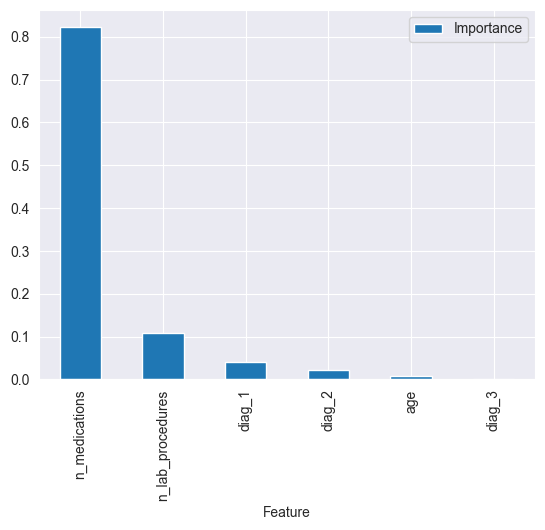

In [186]:
## Feature Importance from SelectFromModel
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

* These are the 6 most important features in descending order. The model was trained on them: 
*['n_medications', 'n_lab_procedures', 'diag_1', 'diag_2', 'age', 'diag_3']*

### Evaluate Pipeline on Train and Test sets

In [200]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[["Actual " + sub for sub in label_map]],
        index=[["Prediction " + sub for sub in label_map]]
        ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [201]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Will readmit', 'Will not readmit']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    4734                    3671
Prediction Will not readmit                5946                    7009


---  Classification Report  ---
                  precision    recall  f1-score   support

    Will readmit       0.56      0.44      0.50     10680
Will not readmit       0.54      0.66      0.59     10680

        accuracy                           0.55     21360
       macro avg       0.55      0.55      0.54     21360
    weighted avg       0.55      0.55      0.54     21360
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    1172                     899
Prediction Will not readmit                1394                    1535


---  Classification Report  ---
                  precision    recall  f1-score   s

The model scored the following:
* Train set:
    - Recall on 'Will readmit' 44% 
    - Precision on 'Will not readmit': 54%
* Test set:
    - Recall on 'Will readmit' 46% 
    - Precision on 'Will not readmit': 52%

The above scores are well below are required 70% on recall for 'Will readmit' and 60% precision on 'Will not readmit'. However, we see that the model did not over fit and we were able to determine the most important features. So using those we will try to see if we can get a better performance.

## Refit pipeline with best features

We can refit the ML pipeline with the most important features to determine whether we get the same result as one fitted with all variables.

In [202]:
best_features

['n_medications', 'n_lab_procedures', 'diag_1', 'diag_2', 'age', 'diag_3']

#### Rewrite the ML Pipelines

In [203]:
def PipelineDataCleaningAndFeatureEngineeringBestFeatures():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=[
            'age', 'diag_1', 'diag_3', 'diag_2'])),
        ('Winsorizer_iqr', Winsorizer(variables=['n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
    ])

    return pipeline_base

In [204]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

#### Split Train and Tests Sets Using Only Most Important Features

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.3,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(17500, 15) (17500,) (7500, 15) (7500,)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med
15705,[80-90),4,70,0,6,0,7,0,Circulatory,Circulatory,Circulatory,no,no,0,1
6016,[70-80),6,52,1,8,0,0,0,Injury,Diabetes,Other,no,no,0,1
24764,[80-90),6,49,1,13,0,0,0,Circulatory,Circulatory,Respiratory,no,no,1,1
11962,[50-60),2,55,0,6,2,0,0,Other,Other,Diabetes,no,no,1,1
15824,[70-80),4,62,0,14,0,0,0,Digestive,Circulatory,Circulatory,no,no,0,1


We filter the sets with the best features.

In [206]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, X_test.shape)
X_train.head()

(17500, 6) (7500, 6)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
15705,6,70,Circulatory,Circulatory,[80-90),Circulatory
6016,8,52,Injury,Diabetes,[70-80),Other
24764,13,49,Circulatory,Circulatory,[80-90),Respiratory
11962,6,55,Other,Other,[50-60),Diabetes
15824,14,62,Digestive,Circulatory,[70-80),Circulatory


### Handle Target imbalance

In [207]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineeringBestFeatures()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(17500, 6) (17500,) (7500, 6) (7500,)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
15705,6.0,70,0,0,0,0
6016,8.0,52,1,1,1,1
24764,13.0,49,0,0,0,2
11962,6.0,55,2,2,2,3
15824,14.0,62,3,0,1,0


In [208]:
X_test.head()

,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
14149,5.0,17,4,2,1,1
8946,12.0,37,2,0,4,2
22378,15.0,43,3,4,0,3
12162,13.0,69,2,2,4,2
4879,11.0,58,2,2,0,3


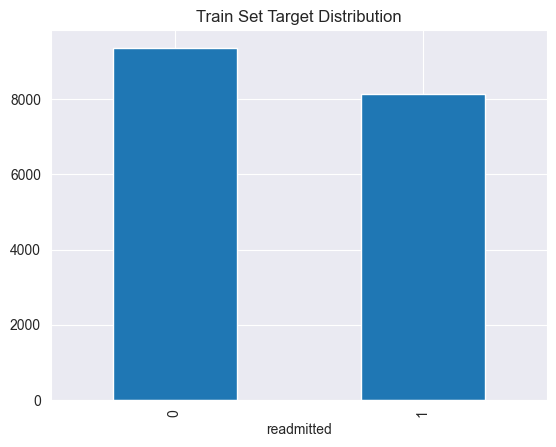

In [209]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [210]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18732, 6) (18732,) (7500, 6) (7500,)


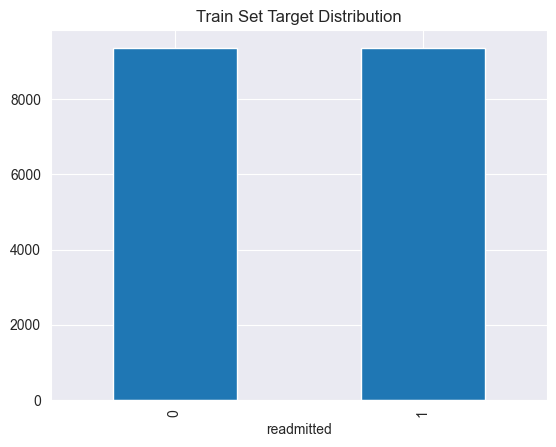

In [211]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### GridSearch CV

In [212]:
models_search = {'RandomForestClassifier': RandomForestClassifier(random_state=42)}

In [213]:
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

In [214]:
params_search = {"RandomForestClassifier":{'model__class_weight': ['balanced'],
                                        'model__max_depth': [None],
                                        'model__max_features': [None],
                                        'model__max_leaf_nodes': [5],
                                        'model__min_samples_leaf': [1],
                                        'model__min_samples_split': [2],
                                        'model__n_estimators': [250]
                                        }
                }

In [215]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                scoring=make_scorer(recall_score, pos_label=1),
                n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Checking the results

In [222]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.607048,0.631326,0.663107,0.02166,balanced,None,None,5,1,2,250


This time the mean_score on recall was improve slightly to 0.631326, using th best features and the best parameters determined previously.

Defining the best classification pipeline

In [223]:
best_model = grid_search_summary.iloc[0, 0]

pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=None, max_leaf_nodes=5,
                                        n_estimators=250, random_state=42))])

In [224]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

### Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['n_medications', 'n_lab_procedures', 'age', 'diag_1', 'diag_2', 'diag_3']


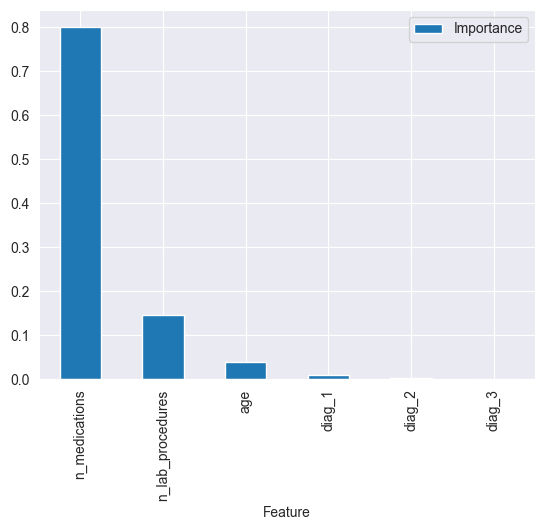

In [225]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [226]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Will readmit', 'Will not readmit'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    4212                    3308
Prediction Will not readmit                5154                    6058


---  Classification Report  ---
                  precision    recall  f1-score   support

    Will readmit       0.56      0.45      0.50      9366
Will not readmit       0.54      0.65      0.59      9366

        accuracy                           0.55     18732
       macro avg       0.55      0.55      0.54     18732
    weighted avg       0.55      0.55      0.54     18732
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    1773                    1352
Prediction Will not readmit                2107                    2268


---  Classification Report  ---
                  precision    recall  f1-score   s

The model scored the following:
* Train set:
    - Recall on 'Will readmit' 45% 
    - Precision on 'Will not readmit': 54%
* Test set:
    - Recall on 'Will readmit' 46% 
    - Precision on 'Will not readmit': 52%

We generally see that the model did not over fit but also didn't reach our targets. Also, the feature importance remained the same.

---

## Refit pipeline using PCA

We now going to try to improve the performance pf the model by using PCA. As we saw on the previous notebook of Feature Engineering, we will still use the previous pipelines and we are going to use all the components of the dataset since the a big number of them is needed to explain more than 80% of the dataset's variance.

In [119]:
def PipelineDataCleaningAndFeatureEngineeringPCA():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=categorical_columns)),
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.4, selection_method="variance")),
    ])

    return pipeline_base

In [120]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=13, random_state=0)),
        ("model", model),
    ])

    return pipeline_base

Split to train and test set

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 15) (20000,) (5000, 15) (5000,)


#### Handle Target Imbalance

In [122]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineeringPCA()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 13) (20000,) (5000, 13) (5000,)


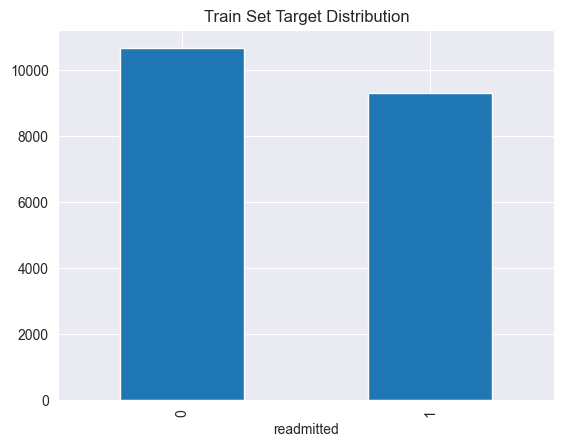

In [123]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [124]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21360, 13) (21360,) (5000, 13) (5000,)


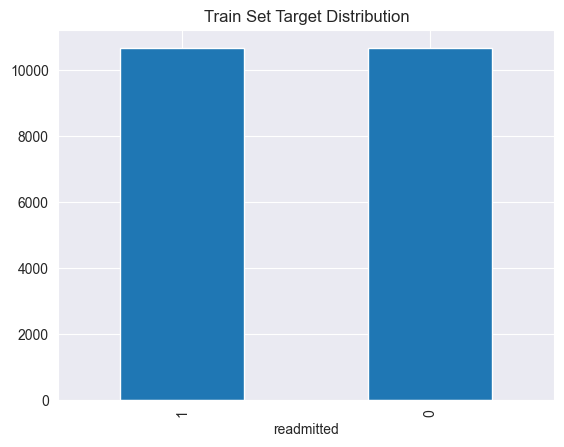

In [125]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

#### GridSearch 

In [128]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "XGBClassifier": XGBClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "LogisticRegression": {}
}

In [129]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [130]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.56367,0.580993,0.608146,0.016296
5,ExtraTreesClassifier,0.55103,0.578558,0.621723,0.025435
1,XGBClassifier,0.540262,0.560768,0.582865,0.015407
2,DecisionTreeClassifier,0.529026,0.546255,0.583333,0.021048
4,GradientBoostingClassifier,0.453652,0.509644,0.549157,0.032118
6,AdaBoostClassifier,0.444288,0.506367,0.546348,0.033775
0,LogisticRegression,0.421816,0.467135,0.507491,0.028981


From the grid search we still get the 'RandomForestClassifier' and the 'ExtraTreesClassifier' as the best performing algorithms.
  - RandomForestClassifier - 0.580993
  - ExtraTreesClassifier - 0.578558

Extensive research

In [133]:
models_quick_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=42),
}

params_quick_search = {
    "RandomForestClassifier":{'model__n_estimators': [150,250],
                            'model__max_depth': [None,15],
                            'model__min_samples_split': [2,75],
                            'model__min_samples_leaf': [1,75],
                            'model__max_leaf_nodes': [5,25],
                            'model__class_weight': ['balanced'],
                            'model__max_features': [ None,'sqrt'],
                            }
}

In [134]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [135]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
14,RandomForestClassifier,0.468165,0.530431,0.570693,0.034254,balanced,None,None,25,75,75,150
12,RandomForestClassifier,0.468165,0.530431,0.570693,0.034254,balanced,None,None,25,75,2,150
44,RandomForestClassifier,0.468165,0.530431,0.570693,0.034254,balanced,15,None,25,75,2,150
46,RandomForestClassifier,0.468165,0.530431,0.570693,0.034254,balanced,15,None,25,75,75,150
42,RandomForestClassifier,0.467228,0.530337,0.571161,0.034891,balanced,15,None,25,1,75,150
...,...,...,...,...,...,...,...,...,...,...,...,...
17,RandomForestClassifier,0.411517,0.507959,0.577247,0.055422,balanced,None,sqrt,5,1,2,250
50,RandomForestClassifier,0.418071,0.507584,0.575843,0.053524,balanced,15,sqrt,5,1,75,150
18,RandomForestClassifier,0.418071,0.507584,0.575843,0.053524,balanced,None,sqrt,5,1,75,150
48,RandomForestClassifier,0.418071,0.50721,0.573034,0.053444,balanced,15,sqrt,5,1,2,150


After the extensive hyperparameter search the mean score on recall did not improve and remained low at 0.530431

In [136]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [137]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': 25,
 'model__min_samples_leaf': 75,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [138]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=13, random_state=0)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=None, max_leaf_nodes=25,
                                        min_samples_leaf=75, n_estimators=150,
                                        random_state=42))])

#### Assess features importance

* These are the 13 most important features in descending order. The model was trained on them: 
['n_emergency', 'n_outpatient', 'n_inpatient', 'change', 'glucose_test', 'n_medications', 'age', 'diag_1', 'n_lab_procedures', 'diag_2', 'diag_3', 'A1Ctest', 'n_procedures']


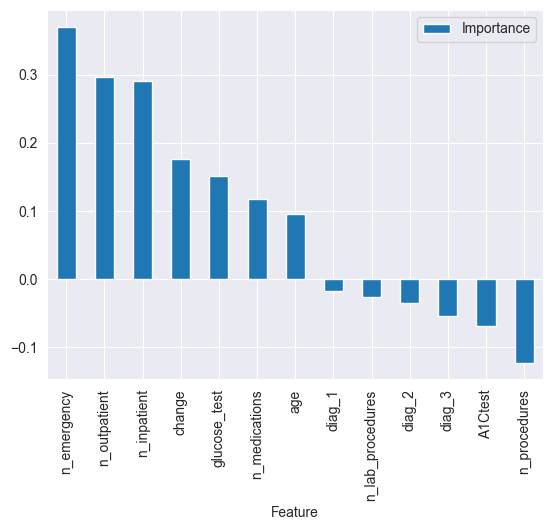

In [139]:
## PCA 
pca = pipeline_clf['PCA']
model = pipeline_clf['model']
# Get the PCA components (coefficients of original features)
components = pca.components_
# Get the feature names
feature_names = X_train.columns

# Calculate the importance of original features by multiplying the component coefficients
# with the feature importances from the model (if the model has such an attribute)
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': components.T @ model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

#### Evaluate Pipeline on Train and Test sets

In [153]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Will readmit', 'Will not readmit']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    7339                    4828
Prediction Will not readmit                3341                    5852


---  Classification Report  ---
                  precision    recall  f1-score   support

    Will readmit       0.60      0.69      0.64     10680
Will not readmit       0.64      0.55      0.59     10680

        accuracy                           0.62     21360
       macro avg       0.62      0.62      0.62     21360
    weighted avg       0.62      0.62      0.62     21360
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual Will readmit Actual Will not readmit
Prediction Will readmit                    1709                    1134
Prediction Will not readmit                 857                    1300


---  Classification Report  ---
                  precision    recall  f1-score   s

The overall performance using PCA was slightly better, but still failed to meet the metrics we set which they were at least 70% on recall for the 'will readmit'. 

* Train set:
    - Recall on 'Will readmit' 69% 
    - Precision on 'Will not readmit': 64%
* Test set:
    - Recall on 'Will readmit' 67% 
    - Precision on 'Will not readmit': 60%

Although we didn't reach the 70% on recall we managed to keep the precision for 'Will not readmit' above 60% which is one of the failure metrics.

---

# Push files to Repo

We will generate the following files:

* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [154]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_readmission/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

### Train Set

In [155]:
print(X_train.shape)
X_train.head()

(21360, 13)


,age,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change
0,0,47,0,21.0,0,1.0,0,0,0,0,0,0,1
1,1,50,1,11.0,0,0.0,0,1,1,1,0,0,0
2,2,66,1,10.0,0,0.0,0,0,0,1,0,1,0
3,2,63,0,28.0,0,0.0,0,2,1,1,1,0,0
4,2,60,2,25.0,3,2.0,4,0,2,0,0,0,1


In [156]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [157]:
y_train

0        1
1        0
2        0
3        1
4        1
        ..
21355    1
21356    1
21357    1
21358    1
21359    1
Name: readmitted, Length: 21360, dtype: int64

In [158]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

In [159]:
print(X_test.shape)
X_test.head()

(5000, 13)


,age,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change
14149,0,17,1,5.0,0,2.5,2,2,0,0,1,0,0
8946,1,37,1,12.0,0,0.0,0,0,1,4,0,0,0
22378,4,43,3,15.0,1,0.0,0,4,4,1,0,0,0
12162,1,69,0,13.0,0,2.5,0,0,0,4,0,0,0
4879,4,58,0,11.0,0,1.0,0,0,0,1,0,0,1


In [160]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [161]:
y_test

14149    1
8946     1
22378    1
12162    0
4879     1
        ..
4022     0
17601    0
4718     1
9376     0
8019     0
Name: readmitted, Length: 5000, dtype: int64

In [162]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines:

* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.

Pipeline responsible for Data Cleaning and Feature Engineering.

In [163]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['age', 'diag_1', 'diag_2', 'diag_3',
                                           'glucose_test', 'A1Ctest'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['time_in_hospital', 'n_procedures',
                                       'n_inpatient', 'n_medications',
                                       'n_lab_procedures'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.4))])

In [164]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_readmission/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

In [165]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=13, random_state=0)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=None, max_leaf_nodes=25,
                                        min_samples_leaf=75, n_estimators=150,
                                        random_state=42))])

In [166]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_readmission/v1/clf_pipeline_model.pkl']

## Feature Importance plot

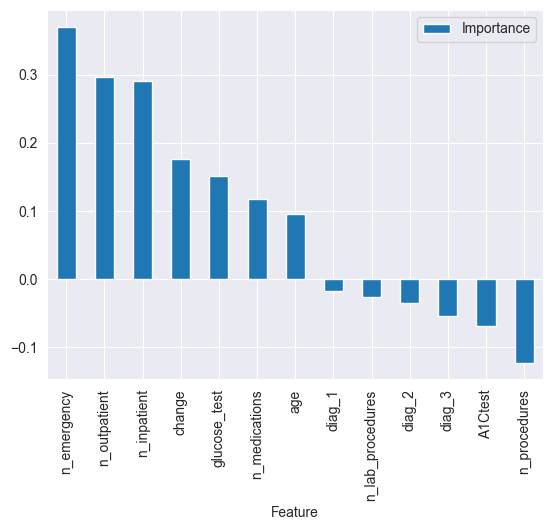

In [167]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

## Conclusions

The model we trained in this notebook did not meet the metric criteria that we have set in our case study to accurately predict patients that are in risk of been readmitted, but remains cautiously reliable on predicting patients that will not readmit.

At this point we could temporarily deploy this model, but we have to warn the users regarding the reliability of the results, until we can develop a more accurate and reliable model. This can be done with further examination of the features and application of more feature engineering techniques and also consider developing an Artificial Neural Network. 